# Mobile Robotics Project Report - Santa Navigation
### **Group 31:** Chiara Delvecchio, Camille Dorster, Junseo Um, Jérôme Courdacy

**Task Distribution**:  
- Chiara: Local Avoidance, Vision, Motion Control
- Camille: Kalman filter, Path Planning, Local Avoidance
- Junseo: Kalman filter
- Jérôme: Vision, Local Avoidance 

# Table of contents

# 1. Introduction: The Mission
Our project is named **"SantaNavigation"**, born from a simple yet urgent necessity: someone had to help Santa Claus deliver gifts efficiently!
In this scenario, our Thymio robot acts as Santa's high-tech sleigh. Its mission is to navigate autonomously from a starting point (the North Pole) to a destination (the Chimney/Goal) while carrying out its delivery duties.
However, the journey is fraught with perils. To succeed, our system must overcome three main challenges:
- **The Mountains (Global Obstacles):** The sleigh must plan a path around static geographic features that are known and mapped.
- **The "Ryanair Planes" (Local Obstacles):** The sleigh must reactively dodge unexpected, unmapped dynamic obstacles (like low-flying budget airlines) that appear suddenly in its path.
- **Vehicle Control:** We must ensure the sleigh doesn't get lost and handles smoothly, filtering noisy signals to provide a comfortable ride for the gifts.

# 2. The Hardware Setup
#### 2.1 The "Eye in the Sky" (Vision System)
To give Santa a complete view of the world, we utilized an *AUKEY Stream Series 1080P HD Webcam*.
- **Placement:** The camera is mounted overhead, positioned as perpendicular to the ground as possible (Nadir view).
- **Role:** This sensor is the core of our Global Perception. Its job is to construct the Global Map, identify the obstacles, localize the Thymio, and pinpoint the target (Goal Position).

#### 2.2 The Sleigh (Thymio)
The vehicle used is the *Thymio*, a differential drive mobile robot. It is equipped with horizontal proximity sensors which detect the local obstacles (Ryanair planes mounted on a box) that the overhead camera will miss by design.



# 3. Software Architecture: Modular Design
The implementation strategy for "SantaNavigation" was driven by the principle of **modularity**. To ensure the main control loop (main.py) remained clean, we delegated all complex mathematical operations, hardware interfaces, and image processing tasks to specialized utility modules ("utils").


This separation allows each module to focus on its specific domain, making the code more robust and maintainable. Below is a breakdown of our utility modules and their responsibilities.

**3.1 vision_utils.py**
This module encapsulates all Computer Vision logic using a class-based approach (Vision class). It takes care of: camera management, automatic calibration, computation of the Homography Matrix, creation of the top-down map, ArUco detection, obstacles detection and finally visualization.

**3.2 pathplanning_utils.py**
This module is responsible for finding the best route. It deals purely with geometry and graph theory, independent of the robot's hardware. We use  Visibility Graph strategy. Then we use A* algorithm to find the shortest path through the visibility graph. Moreover in this utils file we also implement a Path Smoothing strategy that includes logic to simplify the path by removing unnecessary collinear waypoints, ensuring the robot doesn't make redundant stops.

**3.3 control_utils.py**
This module groups motor control, path following, and local avoidance into a compact control layer used throughout our system (look at section X).

**3.4 ekf_pose.py**
This module contains the class EKFPose which has all the functions and variables needed to execute the EKF. It takes care of computation of new position with EKF and visualization function.


# 4. Environment Design & Computer Vision Strategies

**Setup Overview:** The environment was designed to simplify reliable vision-based detection. A solid green surface was used as the background to maximize contrast, while obstacles were colored in a distinct red. ArUco markers were placed to localize the Thymio robot, the goal, and to calibrate the camera system. In the following sections, we describe in detail the calibration, localization, and obstacle detection strategies implemented to enable accurate navigation.

**ArUcos** - For precise and reliable localization of the robot, the goal, and for calibrating the camera system, we utilized ArUco Markers.
What is an ArUco Marker? An ArUco marker is a synthetic square marker composed of a wide black border and an inner binary matrix (a pattern of black and white squares). The black border facilitates its fast detection in the image and the binary codification allows its identification and the application of error detection and correction techniques. 
How we used them (Indices 0-5): We assigned specific roles to specific Marker IDs to automate the entire setup:
1. **Automatic Calibration (IDs 2, 3, 4, 5):** We placed four markers at the corners of our arena. The system automatically detects these four corners to perform a perspective transform. See Homography section for more information.

2. **Measuring dimensions:** By measuring the distance between two ArUco at the ends of the green background and comparing it with a known measurement (the size in cm of the background) we can understand the px/cm ratio and consequently calculate the radius of the Thymio in px.

3. **The Sleigh (ID 0):** A specific marker is attached to the Thymio. This allows the system to calculate the robot's (x, y) position and its orientation (theta). Knowing the robot's heading is essential for our path-following control logic. (Note: in the main system we do not rely directly on these raw camera measurements of position and orientation that are later refined using a Kalman Filter, as discussed in Section X).

4. **The Goal (ID 1):** Another marker designates the target destination (x,y).

**Why ArUco?** ArUco markers were chosen because they are inexpensive, easy to deploy, and provide fast and reliable pose estimation using only a camera. 

#### 4.1 Vision initialization:

The goal of the initialization is to provide the Vision object with all the necessary attributes to perform all the tasks needed. We provide constants like the `camera_index` and camera frame dimensions `cam_width` and `cam_height`. We also define the dimensions of the post-calibration frame, corresponding to the `map_width`and `map_height` of our robot's map in pixels. We also provide information about the ArUco indices corresponding to the thymio and goal using `thymio_marker_id` and `goal_marker_id`. Finally we pass it the transformation matrix path in `matrix_file_path`.

During the initialization of the Vision system, we connect to the webcam using the index provided and try to load it if it already exists. If it doesn't, we compute it.

In this code, we run the Vision unit initialization on a test frame (not on live camera feed). When running this code, the user will be asked to verify the calibration phase: press s if all ArUco corners are detected.

In [1]:
import cv2
import vision_utils as vu
import matplotlib.pyplot as plt

# --- CONFIG ---
CFG = {
    "CAM": 0, "RES": (1920, 1080), "MAP": (1000, 700), "MTX": "calibration_matrix.npy",
    "IDS": (0, 1), "AREA": 100,
    "THRESH": (600, 1000), "GAIN": 0.06, "BLIND": 0.5, "KIDNAP": 60
}

raw_frame = cv2.imread("raw_frame.png")
vision = vu.Vision(CFG["CAM"], *CFG["RES"], *CFG["MAP"], CFG["MTX"], *CFG["IDS"], CFG["AREA"], test_frame = raw_frame)

2025-12-04 22:14:24.841 python[11251:26961562] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


#### 4.2 Perspective Transformation: Homography

In order to work only with the the map and not the whole raw camera frame, we need to perform a transformation called homography. Homography allows us to, using a homography matrix, transform our raw frame from the camera to a map-specific frame. This allows us to navigate our map with coherent pixels to cms equivalences.

In order to compute the homography matrix, we need to find four points in our raw frame which we know the raw coordinates of, as well as their post-transformation coordinates. In order to do this, we use four corner AruCos. We get their raw coordinates, corresponding to the coordinates of the corners of our map. Since these points ar the map corners, we can easily obtain their post-transformation coordinates using the transformed frame width and height. The map will then be 1000 x 700 pixels, corresponding to 1 pixel = 1 $mm^2$.

During the calibration, the camera system detects the corner ArUcos automatically but a user confirmation is required to make sure that the obtained corner coordinates are correct.

Once computed, the matrix is stored at the indicated path and can be reused while the camera and map setup doesn't change. We can now obtain the post-transformation warped frame that we will use in the rest of the project. Now, we are ready to detect the global obstacles.

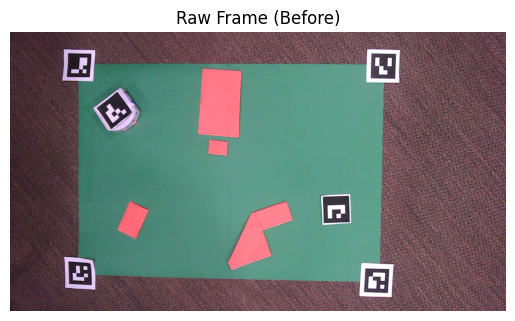

In [3]:
plt.imshow(cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Raw Frame (Before)')
plt.show()

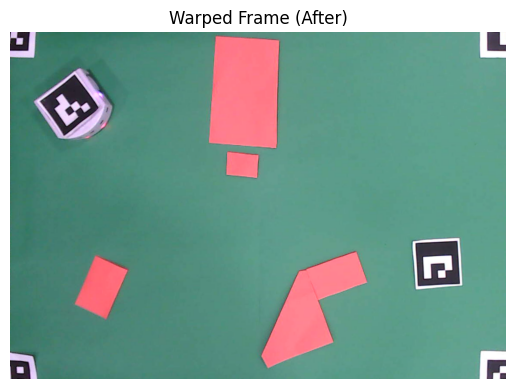

In [4]:
warped_frame = vision.get_warped_frame(raw_frame)

plt.imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Warped Frame (After)')
plt.show()

#### 4.2 Global Obstacle Detection

##### 1-Color Thresholding and Mask  
To ensure robust obstacle detection we engineered the environment with high chromatic contrast and we use HSV color thresholder to isolate the desired lower/upper **HSV (Hue, Saturation, Value)** color range. As said before, we used:
- **Background:** A solid Green surface.
- **Obstacles:** Objects of a distinct Red color.

**Why HSV?** Among simple and fast alternatives such as BGR and grayscale, HSV stands out as the most reliable choice for this task. BGR is often unstable, as a “red” object may appear as a dark maroon under shadow, causing significant variation across all three channels. Similarly, a grayscale thresholding approach was excluded because it discards chromatic information, making red and green objects potentially indistinguishable when they share similar luminance or are affected by uneven lighting.


In contrast, HSV preserves color information more robustly: the hue remains relatively constant even when brightness fluctuates, and the red objects in our scene are highly saturated compared to the black-and-white ArUco marker. This makes red–green separation significantly more stable against shadows and illumination changes.


*Limitations:* It is important to mention that despite the robustness of HSV, the specific threshold values for the filter are still dependent on the ambient light. Drastic changes in room lighting may require re-tuning of these thresholds.


To address this, we developed a dedicated Python tool, *hsv_tuner.py*, which allows manual adjustment of the threshold ranges in real time. This tool enables us to tweak the HSV values and immediately visualize their effect on the filtered image, making re-tuning faster and more controlled.
Once the red regions are isolated through HSV thresholding, we apply a Gaussian Filter and a morphological opening to remove noise and obtain a clean binary mask. Since the Thymio robot also emits red light from its LEDs, we explicitly exclude it from detection by drawing a circular mask at the estimated robot position, with a radius matching its physical size.

##### 2-Polygonal Approximation
The resulting mask is then converted into vector shapes through *_mask_to_polygons()*, which extracts contours, filters out small artifacts, and approximates them into polygons. Finally, *_expand_and_merge_polygons()* enlarges these polygons by the robot radius and merges overlaps using geometric buffering, producing smooth obstacle boundaries that guarantee safe clearance for navigation. 
These design choices serve two practical purposes. First, expanding each polygon by the radius of the robot allows us to treat the Thymio as a single point during path planning since the free space already accounts for its physical footprint. Second, merging nearby expanded polygons is particularly beneficial for the efficiency of our visibility graph planner: the algorithm’s complexity increases with the number of vertices, so reducing multiple close obstacles into a single unified polygon decreases graph size, resulting in faster computation and more scalable navigation performance.

**Implementation note:** Obstacle detection is performed in the main script but **outside the main loop**, because the global obstacles remain static throughout the task. Running detection in real time is unnecessary and could even be problematic: if the robot accidentally occludes an obstacle from the camera’s perspective, the detected obstacle would be altered, potentially modifying the planned path at runtime, which is undesirable for stable navigation.


**Technical Note:** Before building the obstacle map, we perform a 2-second **camera warm-up** to allow auto-exposure and white-balance to stabilize and to flush initial buffered frames. This prevents the first detection cycle from misinterpreting the scene (e.g., overexposed frames), avoiding incorrect maps that could mislead the planner.

Right after warm-up, obstacle detection is computed using the median of multiple (5) consecutive frames rather than a single snapshot. Taking the pixel-wise median reduces sensor noise and removes transient artifacts, ensuring that only persistent red regions are classified as obstacles. This produces a clean, reliable static map for navigation.


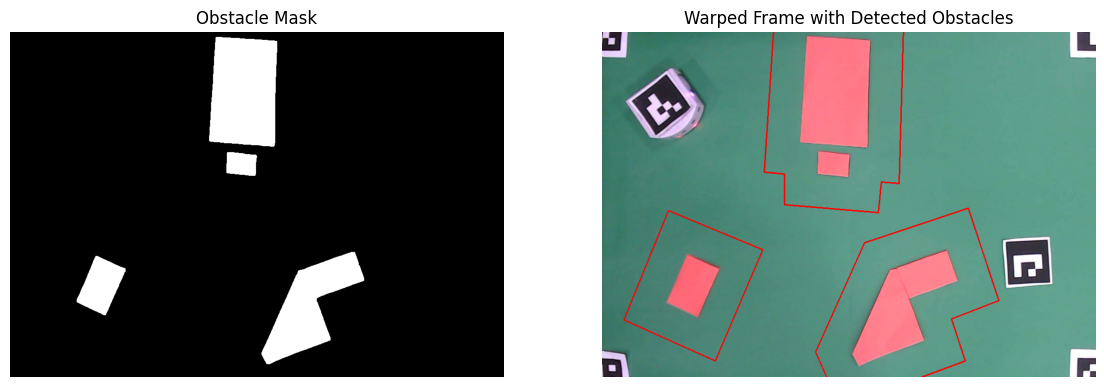

In [5]:
obstacles, obstacle_mask = vision.detect_obstacles(frame = warped_frame)
obstacles_frame = warped_frame.copy()
vision.draw(frame = obstacles_frame, obstacles = obstacles)

fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].imshow(obstacle_mask, cmap='gray')
axs[0].set_title("Obstacle Mask")
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(obstacles_frame, cv2.COLOR_BGR2RGB))
axs[1].set_title("Warped Frame with Detected Obstacles")
axs[1].axis('off')
plt.show()

##### 3 - Thymio and Goal Detection
Here we get the position of both the Thymio and the Goal using ArUco detection. The pose for the Goal is just (x,y) while for the Thymio we also get the angle theta. This is just the raw position taken from the camera that will be needed after for filtering and global navigation.

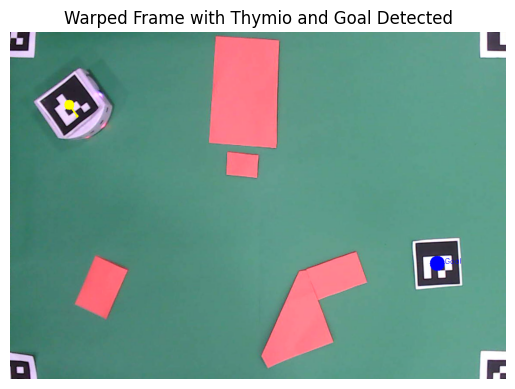

In [6]:
thymio_pose = vision.get_thymio_pose(warped_frame)
goal_pos = vision.get_goal_pos(warped_frame)
pose_frame = warped_frame.copy()
vision.draw(frame = pose_frame, pose=thymio_pose, goal=goal_pos)
plt.imshow(cv2.cvtColor(pose_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Warped Frame with Thymio and Goal Detected')
plt.show()


*Note:* We delete the calibration matrix to recomputed for the main run.

In [7]:
vision.delete_matrix()

# 5. Path Planning with Visibility Graph and A* — Detailed Rationale and Validation

#### 5.1 Problem Formulation and Configuration-Space Modeling

##### Robot and Clearance
We treat the robot as a point by inflating each obstacle polygon by at least the robot radius (configuration space). This “growing” guarantees that any straight segment planned between two points in free space is collision-free for the real robot. It also prevents shortest paths from legally “grazing” uninflated corners that would be unsafe in practice.  

In our code, we assume polygons are already grown before planning; feasibility is then enforced downstream by geometric tests in `visible(...)` and `segment_hits_polygon(...)`.

##### Start/Goal Validity
Before adding edges, we check that neither start nor goal lies inside a grown polygon using `point_in_polygon(...)`; otherwise, planning is rejected.

---

#### 5.2 Visibility-Graph Construction (Why and How)

**Why Visibility Graphs**
In polygonal maps with grown obstacles, Euclidean shortest paths are piecewise-linear and run along straight segments that are “tangent” to obstacle hulls. Therefore, the shortest route between two points lies on the visibility graph:  

- **Nodes**: start, goal, and obstacle vertices  
- **Edges**: connect node pairs whose segment lies entirely in free space  

Compared to a grid, this approach preserves geometric optimality with many fewer states and avoids “staircasing.”

##### How We Build It
- **Nodes**: `build_visibility_graph(...)` collects start, goal, and all vertices; it deduplicates them by rounding to avoid numerical duplicates.
- **Edge Feasibility**: For each pair `(a, b)`, `visible(...)` checks two conditions:  
  1. Endpoints are outside all polygons (`point_in_polygon(...)`)  
  2. Segment `a-b` does not intersect any polygon edge (`segments_intersect(...)` via `segment_hits_polygon(...)`)
- **Shared-Vertex Policy**: We allow a segment to touch a polygon exactly at a shared vertex (`allow_shared_endpoint=True`). This preserves valid shortest paths that pivot around corners after obstacle growing while still forbidding edge crossings. All other contacts count as collisions.

---

#### 5.3 Geometric Robustness (Floating-Point and Near-Degenerate Cases)
- **Orientation and Collinearity**: We use `orient(...)` with a small epsilon to classify left/right/collinear reliably.  
- **On-Segment Checks**: `on_segment(...)` decides if a collinear point lies on a segment.  
These tolerances avoid false intersections when vertices are nearly collinear or coordinates are rounded.

---

#### 5.4 Search Objective and the A* Algorithm

**Objective**
Minimize total Euclidean path length \(L\) over the visibility graph.

##### State Metrics
- \(g(u)\): best-known cost from start to node \(u\)  
- \(h(u)\): Euclidean distance from \(u\) to goal  
- \(f(u) = g(u) + h(u)\): priority in the min-heap (`heapq`)

##### Expansion Loop
1. Pop the node \(u\) with smallest \(f\).  
2. If \(u\) is the goal, reconstruct the path through parent pointers (`parent[v] = u` when updating `g(v)`).  
3. Otherwise, for each neighbor \(v\) with edge weight \(w\):  
   - Compute `ng = g(u) + w`  
   - If \(v\) is unseen or `ng < g(v)`, update `g(v)`, set the parent, and push `f(v) = ng + h(v)`  

##### Closed Set
Once \(u\) is popped and added to closed, it is not re-relaxed (Euclidean \(h\) is consistent, so this is correct).

##### Efficiency
A* explores far fewer nodes than Dijkstra (with \(h \equiv 0\)) because the heuristic directs the search toward the goal without sacrificing optimality.

---

#### 5.5 Path Post-Processing and Interface

**Waypoint Cleanup**
`simplify_collinear(...)` removes strictly collinear intermediate nodes so waypoints mark only true direction changes. This does not alter total length and produces cleaner commands for the controller.

**Pipeline Assembly**
`plan_path(...)` assembles the pipeline: it builds the graph, runs A*, then simplifies and returns the waypoints and the total length.

#### 5.6 Example

In this example implementing our optimal path finder, we set up a line-based map with polygonal obstacles already grown (inflated by robot radius in real simulation). The start and goal are represented respectively by a green dot and a blue star.

Results shown:
The light-blue lines are all visible "roads" (edges) between nodes; the red line is the shortest path. Waypoints which are the nodes forming the shortest path as well as the path length are given. The path stays in free space and does not cross obstacles thanks to obstacle growing and the visibility test. 

Longueur de chemin: 1.205 m
Waypoints:
  (0.1, 0.1)
  (0.8, 0.75)
  (0.95, 0.95)


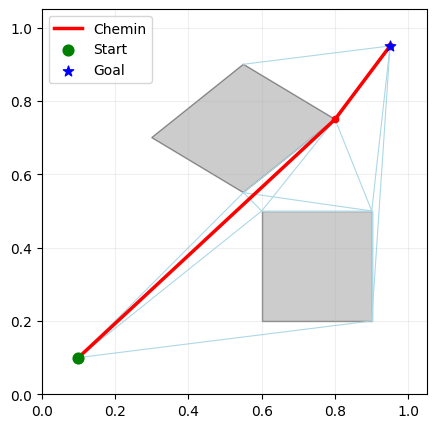

In [8]:
import matplotlib.pyplot as plt
import pathplanning_utils as pu


# ---------- Scène de test ----------
# Obstacles déjà “gonflés” (mètres). Deux polygones convexes pour la démo.
polygons = [
    [(0.6, 0.2), (0.9, 0.2), (0.9, 0.5), (0.6, 0.5)],      # rectangle
    [(0.3, 0.7), (0.55, 0.55), (0.8, 0.75), (0.55, 0.9)]   # quadrilatère
]
start = (0.1, 0.1)
goal  = (0.95, 0.95)
safety = 0.00  # tu peux mettre 0.02 pour ajouter une marge

# Planification
path, total_len= pu.plan_path(start, goal, polygons, safety=safety)
graph = pu.build_visibility_graph(start, goal, polygons, safety=safety)  # for plotting edges

print(f"Longueur de chemin: {total_len:.3f} m")
print("Waypoints:")
for p in path or []:
    print(f"  {p}")

# ---------- Visualisation ----------
fig, ax = plt.subplots(figsize=(5,5))
# Obstacles
for P in polygons:
    xs = [p[0] for p in P] + [P[0][0]]
    ys = [p[1] for p in P] + [P[0][1]]
    ax.fill(xs, ys, color='gray', alpha=0.4, edgecolor='k')

# Graphe de visibilité (toutes les arêtes)
for u, nbrs in graph.items():
    for v, _ in nbrs:
        # tracer chaque arête une seule fois
        if u < v:
            ax.plot([u[0], v[0]], [u[1], v[1]], color='lightblue', linewidth=0.8, zorder=1)

# Chemin final
if path:
    px = [p[0] for p in path]
    py = [p[1] for p in path]
    ax.plot(px, py, '-r', linewidth=2.5, label='Chemin', zorder=3)
    ax.scatter(px, py, c='r', s=20, zorder=4)

# Start/Goal
ax.scatter([start[0]], [start[1]], c='green', s=60, marker='o', label='Start', zorder=5)
ax.scatter([goal[0]], [goal[1]], c='blue',  s=60, marker='*', label='Goal', zorder=5)

ax.set_xlim(0.0, 1.05)
ax.set_ylim(0.0, 1.05)
ax.set_aspect('equal')
ax.grid(True, alpha=0.2)
ax.legend()
plt.show()

# 6. LOCAL AVOIDANCE
While the vision-based global map allows the robot to plan an optimal path around static obstacles, real environments are unpredictable. A new object may appear on the floor, or the robot may encounter something unseen by the camera. To handle these situations, we implemented a two-state Finite State Machine (FSM) that governs the navigation strategy in real time.

The first state (**Global Navigation**) is active during normal operation. If  max(prox[:5]) is remain below 1000, the robot follows the planned A* path, using the PathFollower controller to steer from one waypoint to the next.
If instead an unexpected obstacle comes dangerously close (any proximity sensor > 1000), the FSM switches to the second state (**Local Avoidance**) where the robot relies on reactive behavior to move away from danger.

To avoid unstable oscillations between behaviours, the system uses hysteresis: entry into avoidance occurs at 1000, whereas a safe return to global navigation is only allowed once readings fall below 600. This gap ensures smooth, decisive transitions rather than rapid back-and-forth switching. When switching back to global navigation we also force the system to recalculate the optimal global path. This choice avoids taking suboptimal paths caused by the local navigation routine.

This hybrid approach allows the robot to follow its planned route efficiently, while still responding to unforeseen obstacles.


![descrizione immagine](local_avoidance.png)

# 7. CONTROL
The control layer serves as the bridge between high-level planning and low-level actuation, ensuring that the robot can both follow a predefined route and react to unexpected obstacles.

#### 7.1 Hardware Abstraction Layer — ThymioController
Motor commands are handled through the ThymioController class in control_utils.py. ThymioController acts as a wrapper for motor commands, allowing the code to set wheel speeds cleanly through the node without interacting directly with hardware variables.
Path execution is handled by the PathFollower class, which receives a sequence of waypoints and drives the robot through them using a proportional controller on the heading error. The controller checks when a waypoint is reached and automatically progresses to the next target, adjusting wheel speeds accordingly.
#### 7.2 Global Navigation — Proportional Control (P-Controller)
During normal operation, the robot follows the sequence of waypoints produced by the A* planner thanks to the PathFollower modules.
Heading control is achieved using a P-controller, where the steering command is proportional to the angular deviation from the waypoint. 

**Why P-Controller?** The P-Controller is easy to tune because it has just one gain parameter Kp and it’s robust enough to drift.  By constantly recalculating the error relative to the current vision-based position, the controller naturally corrects for physical disturbances like wheel slippage or uneven terrain without needing complex odometry models.


*Limitations:* We are aware that a small residual steady-state error may persist and that high gain values can cause overshoot or oscillation in tight curves. 


#### 7.3 Local Navigation
If the proximity sensors detect an unexpected object, the FSM switches to Local Avoidance and the controller adopts a logic where stronger readings on one side increase the speed of the opposite motor, steering the robot away from obstacles reflexively.


**Why do we choose this strategy?** This represents a good strategy because it has zero-latency response and a lightweight computation that is ideal alongside vision processing.


# 8. Extended Kalman Filter (EKF) for Robot Pose Estimation

#### 8.1 State Representation

We represent the robot's state as a vector of three variables:

$$
\mathbf{x} = 
\begin{bmatrix}
x \\
y \\
\theta
\end{bmatrix}
$$

where:  

- \(x, y\) are the robot's position in mm,  
- $\theta$ is the robot's orientation in radians.

The robot receives odometry measurements from the wheel encoders:

$$
\mathbf{u} = 
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
$$

where:

- $v = \frac{v_L + v_R}{2}$ is the linear velocity (mm/s),  
- $\omega = \frac{v_R - v_L}{L}$ is the angular velocity (rad/s),  
- $v_L, v_R$ are the left and right wheel speeds,  
- $L$ is the distance between the wheels.

---

#### 8.2 Prediction Step

The EKF prediction propagates the state using the odometry-based motion model:

$$
\begin{aligned}
x_{k+1} &= x_k + v \sin(\theta_k) \, \Delta t \\
y_{k+1} &= y_k - v \cos(\theta_k) \, \Delta t \\
\theta_{k+1} &= \theta_k + \omega \, \Delta t
\end{aligned}
$$

where $\Delta t$ is the elapsed time since the last measurement.

The Jacobian of the motion model with respect to the state is:

$$
G = 
\begin{bmatrix}
1 & 0 & -v \cos(\theta) \Delta t \\
0 & 1 & -v \sin(\theta) \Delta t \\
0 & 0 & 1
\end{bmatrix}
$$

The predicted covariance is computed as:

$$
\mathbf{P}_{k+1|k} = G \mathbf{P}_k G^\top + Q
$$

where \(Q\) is the **process noise covariance** representing the uncertainty in odometry:

$$
Q = 
\begin{bmatrix}
Q_x & 0 & 0 \\
0 & Q_y & 0 \\
0 & 0 & Q_\theta
\end{bmatrix}
$$

---

#### 8.3 Update Step

The EKF incorporates measurements from a **vision system** (Aruco marker detection) to correct the predicted state.  

For position measurements:

$$
\mathbf{z}_{pos} = 
\begin{bmatrix}
x_{meas} \\
y_{meas}
\end{bmatrix}, 
\quad
H_{pos} =
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0
\end{bmatrix}
$$

For orientation measurements:

$$
z_\theta = \theta_{meas}, 
\quad
H_\theta = \begin{bmatrix} 0 & 0 & 1 \end{bmatrix}
$$

The measurement residual is:

$$
\mathbf{y} = \mathbf{z} - h(\mathbf{x})
$$

The Kalman gain is:

$$
K = \mathbf{P}_{k+1|k} H^\top (H \mathbf{P}_{k+1|k} H^\top + R)^{-1}
$$

The state and covariance are updated as:

$$
\mathbf{x}_{k+1} = \mathbf{x}_{k+1|k} + K \mathbf{y}
$$

$$
\mathbf{P}_{k+1} = (I - K H) \mathbf{P}_{k+1|k}
$$

The measurement noise covariance \(R\) is:

$$
R =
\begin{bmatrix}
R_{posx} & 0 & 0 \\
0 & R_{posy} & 0 \\
0 & 0 & R_\theta
\end{bmatrix}
$$

#### 8.4 EKF Parameter Tuning

##### 8.4.1 Tuning of parameters `Qx`, `Qy`, `Qθ` of the matrix Q

The EKF prediction step uses wheel odometry to estimate the robot's pose between two measurements. For a differential-drive robot, the linear and angular velocities are obtained from the left and right wheel encoder speeds:

$$
v = \frac{v_L + v_R}{2}, \quad
\omega = \frac{v_R - v_L}{L}
$$

and the pose is propagated according to:

$$
x_{k+1} = x_k + v \cos(\theta_k) \, dt, \quad
y_{k+1} = y_k + v \sin(\theta_k) \, dt, \quad
\theta_{k+1} = \theta_k + \omega \, dt
$$

Odometry is inherently imperfect due to wheel slip, encoder quantization, and uneven wheel radii, which leads to a progressive divergence between the predicted pose and the true trajectory.

These uncertainties are represented in the process noise matrix:


$$
Q = 
\begin{bmatrix}
Q_x & 0 & 0 \\
0 & Q_y & 0 \\
0 & 0 & Q_\theta
\end{bmatrix}
$$


The tuning of these parameters determines how much the EKF trusts its internal motion model compared to external measurements.

##### 8.4.2 Tuning Procedure

1. **Initial conservative values**  
   Small values of `Qx`, `Qy`, and `Qθ` were first used so the filter strongly trusts odometry. This makes the prediction smooth but prevents the filter from reacting quickly to measurement corrections.

2. **Observation of drift in real experiments**  
   Several runs were performed where the robot moved along straight lines and rotations. The raw odometry trajectory was compared with the external vision-based pose. The drift rate was measured and used as an empirical baseline.

3. **Incremental increase of `Qx` and `Qy`**  
   - These parameters were gradually increased until the EKF became responsive enough to correct lateral and longitudinal drift as soon as new measurements arrived, without overreacting.  
   - Too-small values caused the filter to “ignore” vision corrections and slowly drift with odometry.  
   - Too-large values resulted in noisy corrections and small oscillations around the vision measurement.  
   - The selected values represent the smallest amount of noise that makes the filter consistently converge back to the vision-based pose after each prediction step.

4. **Tuning of `Qθ`**  
   - Gyro drift was evaluated by observing repeated in-place rotations.  
   - `Qθ` was increased until the EKF corrected heading errors quickly while maintaining a stable orientation estimate.  
   - Too small a value caused slow correction of heading drift, while too large a value produced jittery orientation estimates.

The resulting process noise values reflect the actual uncertainty level of the robot’s odometry: the EKF trusts odometry for short-term motion, but allows external measurements (vision) to dominate whenever they reveal drift. This tuning results in a filter that is both stable and reactive, providing an accurate real-time pose estimate.

---

##### 8.4.3 Tuning of `R`

The measurement noise matrix `R` models the uncertainty of the pose estimates provided by the vision system. In our setup, the robot carries an **Aruco marker**, detected by a webcam to measure its position `(x, y)` and orientation `θ`:

$$
R =
\begin{bmatrix}
R_{posx} & 0 & 0 \\
0 & R_{posy} & 0 \\
0 & 0 & R_\theta
\end{bmatrix}
$$

The tuning was performed using **static measurements only**:

1. The robot was placed stationary in front of the camera, and the ArUco marker was repeatedly detected.  
2. The variance of the measured `x`, `y`, and `θ` values was computed and directly used as `Rposx`, `Rposy`, and `Rθ`. This captures the intrinsic noise of the camera detection system due to pixel jitter, lens distortions, and marker corner detection errors.

### Effect of R values on EKF behavior

- **Smaller R values** → the EKF trusts the camera measurements more. This results in quicker corrections of any odometry drift, but can make the state estimate react strongly to tiny pixel-level fluctuations, producing jittery or unstable estimates.  
- **Larger R values** → the EKF trusts the odometry more and relies less on the camera. Corrections from vision are smoother but slower, so odometry drift persists longer before being corrected.

By using the measured static variances, the filter balances stability and responsiveness: it trusts the ArUco detection enough to correct odometry errors while ignoring small detection fluctuations.

#### 8.5 EKF Usage in the Main Program

In the main loop, the EKF estimates the robot's pose `[x, y, θ]` by combining **wheel odometry** and **ArUco vision measurements**:

1. **Predict step (odometry)**  

Wheel encoder speeds are converted to linear and angular velocities:

$$
v = 0.5 \cdot (s_L + s_R) \cdot \text{SPEED\_TO\_MMS}, \quad
\omega = -(s_R - s_L) \cdot \text{omega\_scale}
$$

Then the EKF propagates the state forward:

u = np.array([v_meas, omega_meas])  
ekf.predict(u)

2. **Update step (ArUco measurements)**

If the robot is detected by the camera, the measured position and orientation are use to correct EKF estimate:

ekf.update_pos(x_mm, y_mm)  
ekf.update_theta(theta_rad)

3. **Retrieve the filtered state**
The updated state is used for planning and control:  
x_hat, P_hat = ekf.get_state()

#### 8.6 Testing
To be sure that the filter was working correctly we plot the EKF predicted position and the standard deviation in x on a straight line path. What we did was try to see how the standard deviation of the predicted position changes when we hide the camera. This allows us to see that the prediction uncertainty grows when the camera input is missing. Moreover, when we get the camera input back, we notice a correction in x position. You can see the resulting plot below.

![descrizione immagine](kalman.png)

#### 8.7 Summary

- The EKF combines **odometry prediction** and **vision updates**.  
- Tuning Q and R balances **responsiveness vs stability**.  
- The resulting filter provides **accurate real-time pose estimates** even in the presence of sensor noise and odometry drift.

# 9. System Logic and Execution Flow
The following part orchestrates the flow of data between perception, state estimation, planning, and control modules within a continuous asynchronous loop.

#### 9.1 Initialization Phase
Before the mission begins, the system performs a critical setup sequence:

1. **Hardware Connection:** The script connects to the Thymio via tdmclient, locks the node, and subscribes to motor speed variables (motor.left.speed, motor.right.speed) required for odometry.
2. **Vision & EKF Setup:**
- The Vision class is initialized (camera setup, matrix loading as seen before).
- The EKFPose filter is instantiated with specific covariance matrices (Q for process noise, R for measurement noise) tuned to the robot's physical characteristics.
3. **Static Mapping:** The system performs a "warm-up" to stabilize the camera, then detect static red obstacles and generate the polygons.

In [6]:
import cv2
import numpy as np
import vision_utils as vu
import pathplanning_utils as pu
import control_utils as cu
import asyncio
import time
import math
from tdmclient import ClientAsync
from ekf_pose import EKFPose   # <- classe ci-dessus

# --- CONFIG ---
CFG = {
    "CAM": 0, "RES": (1920, 1080), "MAP": (1000, 700), "MTX": "calibration_matrix.npy",
    "IDS": (0, 1), "AREA": 100,
    "THRESH": (600, 1000), "GAIN": 0.06, "BLIND": 0.5, "KIDNAP": 60
}

#1) Connect to Thymio
client = ClientAsync()
try:
    print("Waiting for Thymio...")
    node = await client.wait_for_node()
    await node.lock()
    print("Connected!")
except Exception as e:
    raise SystemExit(f"Connection Failed: {e}")

# Ensure we can read motor speeds
await node.wait_for_variables({"prox.horizontal", "motor.left.speed", "motor.right.speed"})

robot = cu.ThymioController(node)
follower = cu.PathFollower(speed=100, gain=2.5)

#2) Initialize Vision
vision = vu.Vision(CFG["CAM"], *CFG["RES"], *CFG["MAP"], CFG["MTX"],
                    *CFG["IDS"], CFG["AREA"])
if not vision.cap:
    await node.unlock()
    raise SystemExit("Vision Error")

#3) EKF initialization (units: mm, mm/s, rad)
mm_per_px = 10.0/(vision.px_per_cm)   # mm/px 
ekf = EKFPose()
seeded = False

# Speed conversions
SPEED_TO_MMS = 0.33 #mm/s per Thymio unit
b_mm = 95.0                          # track width (mm) à mesurer
omega_scale = SPEED_TO_MMS / b_mm    # rad/s per (Thymio unit)

#4) Obstacle Detection
print("Camera Warmup (2 seconds)...")
warmup_end = time.time() + 2.0
while time.time() < warmup_end:
    vision.get_warped_frame()
    await asyncio.sleep(0.01)

print("Mapping static obstacles...")
obs_contours, mask = vision.detect_obstacles()
if not obs_contours:
    print("WARNING: No obstacles detected! Check lighting.")
planner_obs = [[tuple(pt[0]) for pt in cnt] for cnt in obs_contours]
debug_view = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
cv2.putText(debug_view, "Initial Map Snapshot", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
cv2.imshow("Map", debug_view)
cv2.waitKey(1500)

Waiting for Thymio...
Connected!
Camera Warmup (2 seconds)...
Mapping static obstacles...


-1

#### 9.2 The Control Loop (The "Brain")
The system enters a while True loop. Each iteration follows the Predict-Update-Plan-Act cycle:

**Step 1: Perception & Prediction (Sensor Fusion)**
This system uses sensor fusion:

- **Proprioception (Odometry):** The script reads the real-time speed of the left and right wheels. Using the differential drive kinematic model, it calculates the linear velocity (v) and angular velocity (omega).
- **EKF Prediction:** Even before the camera processes a frame, the EKF predicts the robot's new position based on the previous state and the wheel velocities. This ensures the robot has a pose estimate even if the camera is blocked (blind navigation).
- **Visual Measurement:** The camera captures a frame. The Vision module detects the ArUco marker to find the "measured" pose (x, y, \theta).
- **EKF Update:**
- - If the marker is visible, the EKF **updates** its predicted state using the visual measurement, correcting any drift accumulated by the wheels.
- - If the marker is not visible (occlusion), this step is skipped, and the robot relies entirely on the prediction (Odometry).

**Step 2: Goal & Planning**
- The goal position is updated from the camera feed (Marker 1).
- **Kidnapping Detection:** The system continuously checks the Cross-Track Error. It calculates the distance between the robot's current filtered position and the line segment it should be following. If this error exceeds a threshold (60 pixels), the system infers that the robot has been manually moved ("kidnapped") or pushed off course. This triggers an immediate re-planning event to generate a new path from the new location.

**Step 3: Hybrid State Machine (Decision Making)**
The decision logic is a Finite State Machine (FSM) with hysteresis, relying on the Filtered Pose:
- **State 0: GLOBAL_NAV (Path Following)**
- - Condition to enter: Proximity sensors < 600.
- - Action: The PathFollower calculates steering commands based on the smooth, filtered EKF pose (pose_for_planner). This eliminates the "jitter" caused by raw camera noise.
- **State 1: LOCAL_NAV (Obstacle Avoidance)**
- - Condition to enter: Proximity sensors > 1000.
- - Action: The robot reacts purely to proximity sensors using Braitenberg logic.

**Step 4: Action & Visualization**
- **Control:** Motor commands are sent to the robot.
- **Visualization:**
- - **Map/Path/Obstacles:** Standard visual overlays.
- - **Covariance Ellipse:** EKF's uncertainty. A small ellipse indicates high confidence (camera active), while a growing ellipse indicates uncertainty (camera blocked, relying on odometry).


In [7]:
# Main Loop
print("Running... Press 'q' to quit.")
state = 0  # 0=Global, 1=Local
try:
    while True:
        frame = vision.get_warped_frame()
        if frame is None:
            break
        prox = list(node["prox.horizontal"])

        # Build u = [v_meas, omega_meas] from wheels
        sL = float(node["motor.left.speed"])
        sR = float(node["motor.right.speed"])
        v_meas = 0.5 * (sL + sR) * SPEED_TO_MMS           # mm/s
        omega_meas = -(sR - sL) * omega_scale              # rad/s
        u = np.array([v_meas, omega_meas], float)

        # EKF predict with u
        ekf.predict(u)

        # Get Thymio pose from vision
        pose = vision.get_thymio_pose(frame)

        # EKF updates (position + theta)
        if pose:
            (px, py), angle_deg = pose
            x_mm = px * mm_per_px
            y_mm = py * mm_per_px
            theta_rad = math.radians(angle_deg)
        
            if not seeded:
                ekf.x[:] = [x_mm, y_mm, theta_rad]
                seeded = True

            ekf.update_pos(x_mm, y_mm)
            ekf.update_theta(theta_rad)

        # Planner/control pose (convert back to pixels)
        if seeded:
            x_hat, _ = ekf.get_state()
            px_hat = int(x_hat[0] / mm_per_px)
            py_hat = int(x_hat[1] / mm_per_px)
            theta_hat = (math.degrees(x_hat[2]))%360
            pose_for_planner = ((px_hat, py_hat), theta_hat)
        else:
            pose_for_planner = pose

        #Get Goal Position from vision
        goal = vision.get_goal_pos(frame)

        # State machine (local avoidance)
        max_prox = max(prox[:5])
        if state == 0 and max_prox > CFG["THRESH"][1]:
            state = 1
        elif state == 1 and max_prox < CFG["THRESH"][0]:
            state = 0
            follower.path = None

        # Planning
        if pose_for_planner and goal:
            needs_plan = False
            if not follower.path:
                needs_plan = True
            elif follower.path and state == 0:
                prev = max(0, follower.current_idx - 1)
                target = follower.path[follower.current_idx]
                if pu.check_kidnapping(pose_for_planner, target, follower.path, prev, CFG["KIDNAP"]):
                    print("Kidnapping detected -> Replan")
                    needs_plan = True

            if needs_plan:
                print("Planning...")
                path, _ = pu.plan_path(pose_for_planner[0], goal, planner_obs, safety=0.0)
                
                if path:
                    follower.set_path(path)
                    print("Path Found!")
                else:
                    print("No Path.")



        # Control
        if pose_for_planner:
            if state == 0:
                l, r, done = follower.get_command(pose_for_planner)
                if done:
                    print("Goal reached!")
                    follower.path = None
                await robot.set_motors(l, r)
            else:
                l, r = cu.calculate_avoidance_commands(prox, 50, 1.8)
                await robot.set_motors(l, r)
        else:
            await robot.stop()

        # Visualization
        # Main map Visualization
        status_text = "GLOBAL" if (state == 0) else "LOCAL AVOIDANCE"
        vision.draw(frame = frame,
                    obstacles = obs_contours, 
                    pose = pose, 
                    kalman_pose = pose_for_planner, 
                    goal = goal, 
                    path = follower.path, 
                    path_idx = follower.current_idx, 
                    state_text = status_text,
                    )
        cv2.imshow("Map", frame)

        # Kalman Visualization
        kalman_var = np.ones((400, 400, 3), dtype=np.uint8) * 255
        cv2.namedWindow("KalmanVariance", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("KalmanVariance", 400, 400)
        if seeded:
            ekf.draw_covariance_ellipse(kalman_var, mm_per_px)
        cv2.imshow("KalmanVariance", kalman_var)


        await asyncio.sleep(0.01)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    await robot.stop()
    await node.unlock()
    vision.release()
    cv2.destroyAllWindows()

Running... Press 'q' to quit.
Planning...
Path Found!
Planning...
Path Found!
Planning...
Path Found!
Planning...
Path Found!
Planning...
Path Found!


CancelledError: 

: 

## Conclusion
This project offered us the opportunity to fully appreciate the complexity behind coordinating multiple components to achieve navigation. By experimenting hands-on, we were able to observe the strengths and weaknesses of each module and to understand how design choices directly influence overall performance. If there is one key takeaway, it is that no universal “perfect recipe” exists in robotics: every solution represents a balance between computational cost, hardware constraints, and the specific conditions of the environment. Ultimately, effective navigation emerges not from ideal components, but from thoughtful compromise and informed engineering decisions.

In the end, we did it —> Santa reached the chimney safely, gifts intact, mission accomplished!